## **I. Data Extraction and Data Visualization :**

**In this part we load the data and we verifie if it's clean, we visualize the data before adding some features**

In [1]:
from function import *

2024-12-25 15:48:08.666437: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-25 15:48:08.671997: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-25 15:48:08.684839: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1735141688.705065   46212 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1735141688.711181   46212 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-25 15:48:08.737541: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

* Scraping data using the Binance API.

In [ ]:
# Extraction Parameters
symbol = 'BTCUSDT'
interval = Client.KLINE_INTERVAL_1DAY
start_date = '1 Jan, 2023'
end_date = '1 Dec, 2024'

# Extract Data
df = get_historical_data(symbol, interval, start_date, end_date)

# Save Data to a CSV File
output_file = "BTCUSDT_daily_2023.csv"
df.to_csv(output_file, index=False)
print(f"Data saved in {output_file}")

Données sauvegardées dans BTCUSDT_daily_2023.csv


* Loads and prepares data from a CSV file.

In [2]:
# Load Data from CSV File
data_file = "BTCUSDT_daily_2023.csv"
df = pd.read_csv(data_file)

# Convert 'timestamp' Column to Datetime Format
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Inspect Data
print(df.head())
print(df.info())

   timestamp      open      high       low     close        volume  \
0 2023-01-01  16541.77  16628.00  16499.01  16616.75   96925.41374   
1 2023-01-02  16617.17  16799.23  16548.70  16672.87  121888.57191   
2 2023-01-03  16672.78  16778.40  16605.28  16675.18  159541.53733   
3 2023-01-04  16675.65  16991.87  16652.66  16850.36  220362.18862   
4 2023-01-05  16850.36  16879.82  16753.00  16831.85  163473.56641   

      close_time  quote_asset_volume  number_of_trades  \
0  1672617599999        1.604794e+09           3218355   
1  1672703999999        2.034683e+09           4036118   
2  1672790399999        2.662766e+09           5097596   
3  1672876799999        3.709833e+09           6310703   
4  1672963199999        2.751080e+09           4842014   

   taker_buy_base_asset_volume  taker_buy_quote_asset_volume  ignore  
0                  48548.78168                  8.038417e+08       0  
1                  60925.25948                  1.017075e+09       0  
2                

- Verifying the presence of missing (NaN) values in the dataset

In [3]:
df.isna().sum()

timestamp                       0
open                            0
high                            0
low                             0
close                           0
volume                          0
close_time                      0
quote_asset_volume              0
number_of_trades                0
taker_buy_base_asset_volume     0
taker_buy_quote_asset_volume    0
ignore                          0
dtype: int64

**Simple display of closing price**


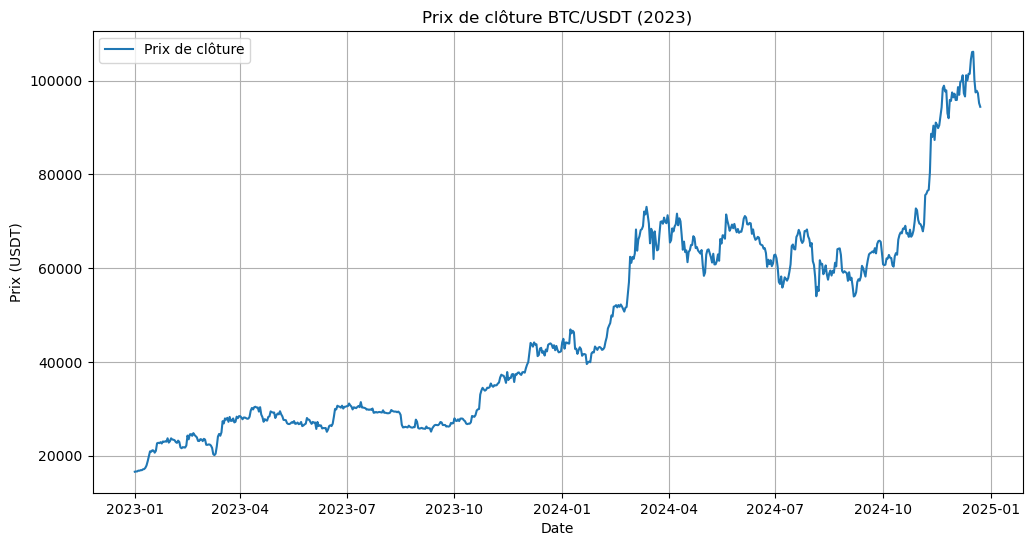

In [4]:
plt.figure(figsize=(12, 6))
plt.plot(df['timestamp'], df['close'], label='Prix de clôture')
plt.title("Prix de clôture BTC/USDT (2023)")
plt.xlabel("Date")
plt.ylabel("Prix (USDT)")
plt.legend()
plt.grid()
plt.show()

**Graph**: This graph shows a strong upward trend in BTC/USDT prices from 2023 to late 2024, with increased volatility toward the end. The sharp rise indicates bullish market sentiment, while the final dip suggests a potential correction.

## **II. Enhance the dataset with additional variables and prepare it for modeling**


**Enriching the database by adding indicators**:

- Relative Strength Index (**RSI**): Measures the speed and magnitude of price movements (momentum).
- Exponential Moving Average (**EMA**): A weighted moving average that prioritizes recent prices, useful for identifying trends.
- Average True Range (**ATR**): Measures market volatility.

These indicators are calculated over the last 14 days.


In [5]:
final_data = add_indicators(df)
final_data

,timestamp,open,high,low,close,volume,close_time,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,ignore,RSI,EMA,ATR
0,2023-01-14,19930.01,21258.00,19888.05,20954.92,393913.74951,1673740799999,8.183072e+09,8659545,197817.55209,4.109568e+09,0,99.633998,18092.438235,495.185000
1,2023-01-15,20952.76,21050.74,20551.01,20871.50,178542.22549,1673827199999,3.710527e+09,5194354,88310.83908,1.835437e+09,0,97.301269,18462.979804,495.509643
2,2023-01-16,20872.99,21474.05,20611.48,21185.65,293078.08262,1673913599999,6.168654e+09,6856434,145352.66942,3.059597e+09,0,97.535299,18826.002497,521.728240
3,2023-01-17,21185.65,21647.45,20841.31,21134.81,275407.74409,1673999999999,5.840586e+09,6440138,137121.64311,2.908227e+09,0,96.083143,19133.843497,542.043366
4,2023-01-18,21132.29,21650.00,20407.15,20677.47,350916.01949,1674086399999,7.399719e+09,7617173,173174.41690,3.652038e+09,0,83.971533,19339.660364,592.100982
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
705,2024-12-19,100204.01,102800.11,95700.00,97461.86,55147.39800,1734652799999,5.487547e+09,7273941,26898.63715,2.677636e+09,0,49.458091,100575.350435,4338.364509
706,2024-12-20,97461.86,98233.00,92232.54,97805.44,62884.13570,1734739199999,6.022845e+09,7429007,29463.23021,2.822939e+09,0,50.116049,100206.029044,4457.085616
707,2024-12-21,97805.44,99540.61,96398.39,97291.99,23483.54143,1734825599999,2.296232e+09,3717638,11726.94119,1.146732e+09,0,49.087622,99817.490505,4363.166643
708,2024-12-22,97292.00,97448.08,94250.35,95186.27,19353.83036,1734911999999,1.857820e+09,3633551,9293.39749,8.920819e+08,0,45.008400,99199.994438,4279.921169


- To prepare for modeling, the data is normalized using the MinMax scaler.

In [6]:
scaled_data = scaling_data(final_data)
scaled_data

,timestamp,open,high,low,close,volume,close_time,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,ignore,RSI,EMA,ATR
0,2023-01-14,0.004289,0.019244,0.003817,0.015831,0.562775,0.000000,0.466340,0.565024,0.561989,0.465954,0.0,1.000000,0.000000,0.000000
1,2023-01-15,0.015806,0.016910,0.011282,0.014891,0.254487,0.001410,0.209202,0.335398,0.250368,0.206133,0.0,0.971200,0.004459,0.000082
2,2023-01-16,0.014908,0.021677,0.011963,0.018429,0.418437,0.002821,0.350526,0.445538,0.412691,0.345994,0.0,0.974090,0.008828,0.006700
3,2023-01-17,0.018429,0.023629,0.014551,0.017856,0.393143,0.004231,0.331665,0.417952,0.389268,0.328700,0.0,0.956161,0.012533,0.011827
4,2023-01-18,0.017828,0.023658,0.009662,0.012706,0.501227,0.005642,0.421303,0.495950,0.491862,0.413681,0.0,0.806633,0.015010,0.024462
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
705,2024-12-19,0.908236,0.937470,0.857518,0.877357,0.077857,0.994358,0.311368,0.473205,0.075609,0.302355,0.0,0.380533,0.992661,0.970034
706,2024-12-20,0.877357,0.886041,0.818471,0.881226,0.088931,0.995769,0.342143,0.483481,0.082907,0.318956,0.0,0.388656,0.988216,1.000000
707,2024-12-21,0.881226,0.900766,0.865382,0.875445,0.032532,0.997179,0.127891,0.237542,0.032435,0.127449,0.0,0.375959,0.983540,0.976294
708,2024-12-22,0.875445,0.877202,0.841193,0.851733,0.026621,0.998590,0.102685,0.231969,0.025510,0.098355,0.0,0.325597,0.976109,0.955283


# **III. Building models to forecast the closing price of the stock.**

## **III.1  Simple Linear Regression** 

In [7]:
# Setting up parameters for a prediction model. Here, the goal is to predict the closing price 60 days in the future using the closing 
#price as the regressor.

prediction_time = 60 # We want to predict the close price 60 days Later 
regressor = ['close'] # We choose One regressor which is the colse price itself
price, target  = data_preprocess(scaled_data, regressor, prediction_time) # Data Processing for the model

- Let’s perform regression analysis and visualize the results.

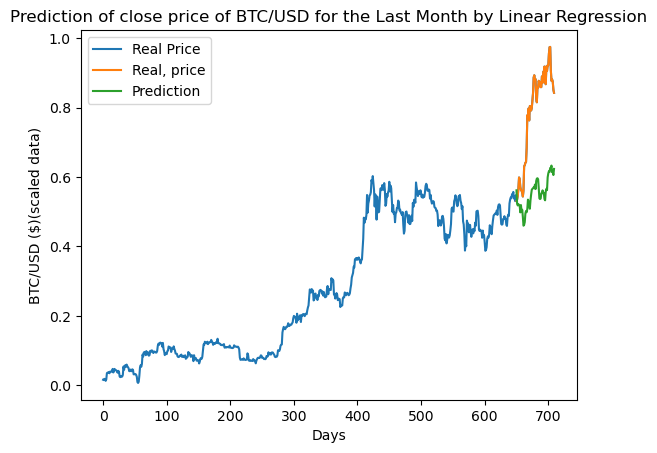

In [8]:
# Performing linear regression on the data.
regression_matrix, future_price, simple_r2 = apply_linear_regression(scaled_data, prediction_time, price, target, regressor)
# Plotting the model's performance on a graph.
visualize_model(regression_matrix, scaled_data)

- We zoom in for better visibility.

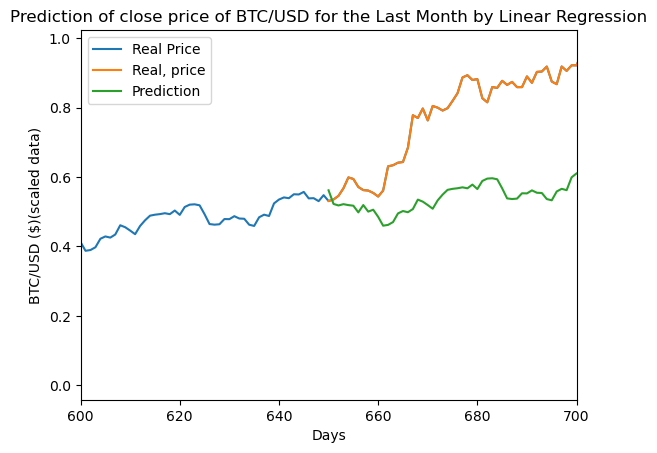

In [9]:
visualize_model(regression_matrix, scaled_data, zoom = [600, 700])

- We calculated the R² indicator to assess the model's accuracy and relevance.

In [10]:
# Showing the R-squared value for the simple linear regression model.
simple_r2

0.7418671198626501

- The predicted values follow the general trend of the real prices but show noticeable deviations.  

- The R² value indicates a moderate fit, suggesting the model captures some but not all price dynamics.  

- The simplicity of the linear regression may limit its ability to fully capture the complexity of price movements. 
 
- Using additional variables or more sophisticated models could enhance prediction accuracy.

Visualization of predictions for the next 60 days, representing the beginning of 2025.

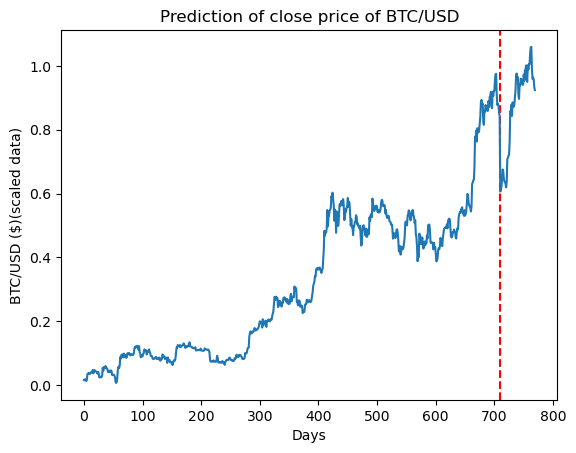

In [11]:
# Plotting the model's future price predictions.
visualize_future(scaled_data, future_price)

The chart predicts a sharp rise in BTC/USD after day 700 but shows a significant dip right after the prediction starts, highlighting potential instability or overfitting in the linear regression model.

## **2. Multiple linear regression.**

- Performing variable selection for multiple linear regression using the correlation matrix.

<function matplotlib.pyplot.show(close=None, block=None)>

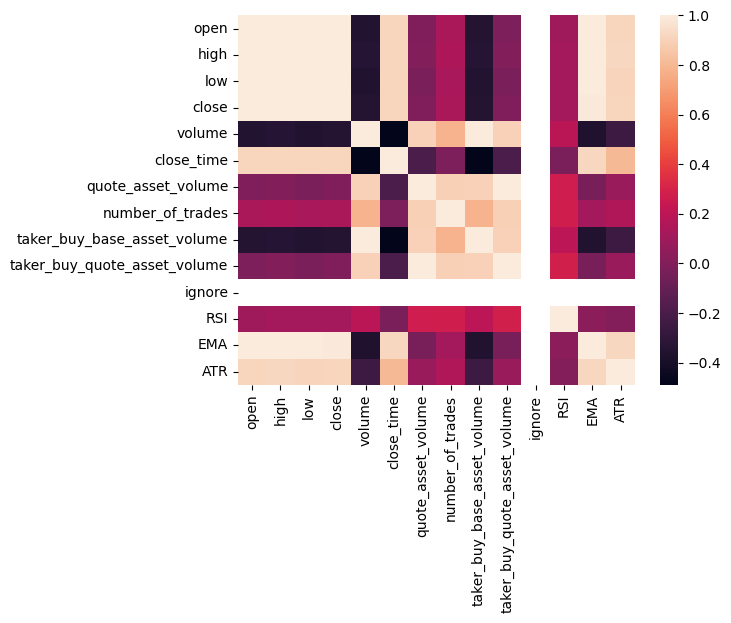

In [12]:
# Generating a correlation matrix.
corr_matrix = final_data.drop('timestamp', axis=1).corr()

# Correlations are visually represented through a heatmap generated with seaborn.
sns.heatmap(corr_matrix)
plt.show

In [13]:
# Identifying feature correlations with the 'close' column using the correlation matrix.
corr_matrix['close']

open                            0.997831
high                            0.999237
low                             0.998874
close                           1.000000
volume                         -0.348455
close_time                      0.915225
quote_asset_volume             -0.008703
number_of_trades                0.141348
taker_buy_base_asset_volume    -0.345387
taker_buy_quote_asset_volume   -0.008500
ignore                               NaN
RSI                             0.117663
EMA                             0.993846
ATR                             0.914236
Name: close, dtype: float64

The Close Price appears to have a relatively strong correlation with the EMA and ATR indicators, making them suitable additions to the regression model.

In [14]:
# Adding 'close,' 'ATR,' and 'EMA' as key features for preprocessing the data.
regressor = ['close', 'ATR', 'EMA']
price, target  = data_preprocess(scaled_data, regressor, prediction_time) 

**Apply Multiple Linear Regression**

In [22]:

regression_matrix, future_price, mult_r2 = apply_linear_regression(scaled_data, prediction_time, price, target, regressor)

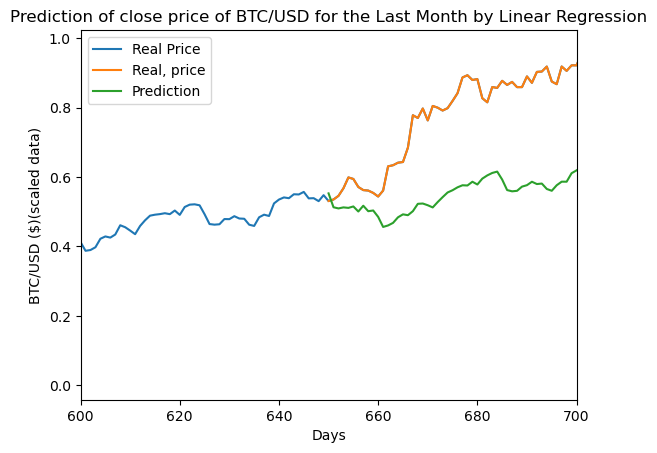

In [23]:
# Plotting the linear regression model's performance.
visualize_model(regression_matrix, scaled_data, zoom=[600,700])

In [24]:
# Comparing the R-squared values of the multivariate model ('mult_r2') to those of the simple model ('simple_r2').
mult_r2, simple_r2

(0.7448677961387806, 0.7418671198626501)

-  The model underestimates the sharp price increase post-day 660, showing limits in handling rapid changes.

- Adding variables naturally increases the R², but this doesn’t guarantee a better model, especially since the improvement here is minimal.

- **Suggestion**: Consider non-linear models and additional evaluation metrics.

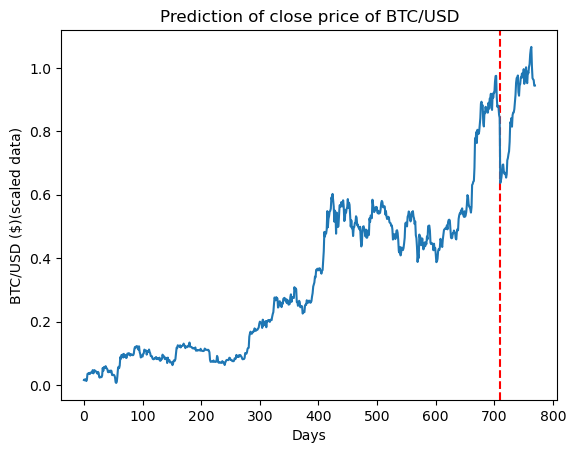

In [25]:
visualize_future(scaled_data, future_price)

The model continues to exhibit a significant dip right at the start of the 2025 prediction, highlighting a recurring problem of instability or overfitting. It is, nevertheless, slightly less pronounced than in the simple linear regression.

## **3. Suport Vector Regression**

- First, the optimal parameters for the SVR model are determined through Cross-Validation.

In [26]:
# Defining a grid of values for 'C' and 'gamma' to optimize hyperparameters in SVM models.

param_grid = {'C': [10**i for i in range(2, 11)], 
              'gamma' : [10**(-i) for i in range(2, 11)]} # Creat a dictionnary of parameters

In [27]:
# Dividing the price and target data into training and test sets, allocating 70% of the data for training.
price_train, _, target_train, _ = train_test_split(price, target, test_size = 0.3)

# The 'cross_validation_parameter' function is utilized to identify the optimal 'C' and 'gamma' values for the model, likely employing a grid search method.
best_C, best_gamma = cross_validation_parameter(param_grid, price_train, target_train)

In [28]:
print(f'The best values are {best_C} for C and {best_gamma} for Gamma')

The best values are 100000 for C and 0.01 for Gamma


- Applying and plotting of the SVR

In [34]:
# Applying a Support Vector Regression (SVR) model with the best 'C' and 'gamma' values found. 
svr_matrix, future_price, r2_svr = apply_svr(scaled_data, prediction_time, price, target, regressor, best_C, best_gamma)

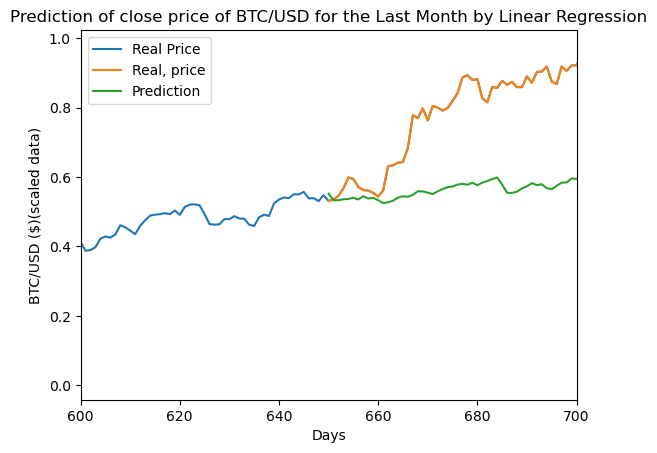

In [35]:

visualize_model(svr_matrix, scaled_data, zoom = [600, 700])

In [36]:
# Displaying the accuracy score of the SVR model.
r2_svr

0.7752870186912056

- **Model Performance:** SVR slightly outperforms the linear regression models but still struggles to capture the sharp upward trend . The 

improvement over linear regression is minimal, highlighting potential limitations in feature selection or model 

tuning.  The improvement in R^2 is modest and does not fully address the prediction gap.

- **Suggestion:** SVR may have limitations with certain data or dynamics, so we are going to try more flexible models.

**Prediction for early 2025**

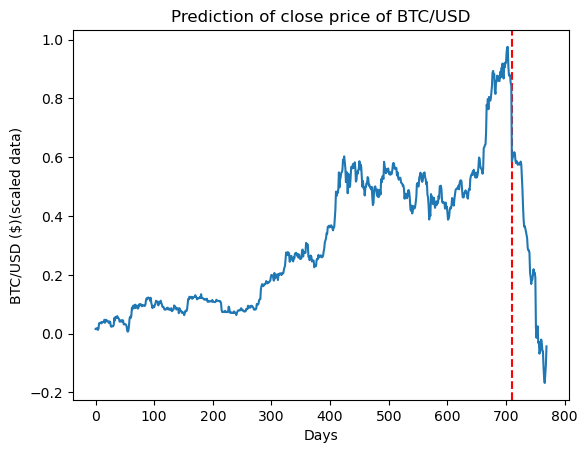

In [37]:
visualize_future(scaled_data, future_price)

**Conclusion :**  The predictions for late 2024 and early 2025 are highly unreliable, showing an unrealistic sharp decline into negative 

values, which is inconsistent with the market context. This highlights serious limitations in the model's ability to capture and generalize future trends.

## **4.  Long short-term memory Model (LSTM)**

The **LSTM** model is a type of deep learning architecture designed for time series prediction. It features memory cells that utilize a set of 

gates to manage information flow. The input gate, forget gate, and output gate work together to determine which information is stored, 

discarded, or passed on, enabling the model to handle sequential data efficiently by selectively retaining or forgetting details.

In [38]:
# Defining the sequence length for time series forecasting.
sequence_length = 20 

The neural network is trained by pairing each value with the value that occurs 20 steps later, enabling it to learn patterns for making predictions.

In [39]:
# Generating sequences from the scaled data based on the defined sequence length.
X, y = create_sequences(scaled_data, sequence_length) # Predictions are made using a time horizon of 20 periods (e.g., 20 days or 20 hours).
# The LSTM is trained on the sequences and makes predictions through the 'lstm_model' function.
y_train, y_test, predicted_values = lstm_model(X, y)

Epoch 1/100


2024-12-25 15:53:37.942027: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/opt/conda/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - loss: 0.1035
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.0451 
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.0158
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0106 
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.0162 
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0134 
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.0072 
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.0045 
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0063 
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.0070 
Epoch 11/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.0056 
Epoch 12/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.0036 
Epoch 13/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0021 
Epoch 14/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.0019 
Epoch 15/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0030 
Epoch 16/100
2/2 ━

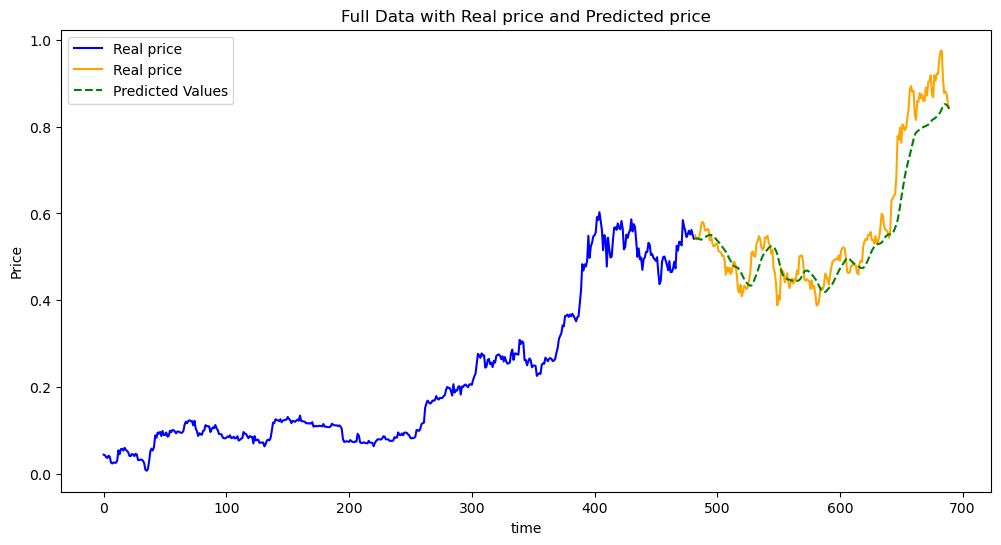

In [40]:
visualize_RNN_prediction(y_train, y_test, predicted_values)

- While the prediction aligns well with the close price, it smooths out variations but retains the key peaks and drops, which are essential for a trader. The smoothing effect, though, results in the drop being delayed.

**Now, to improve our model, the next step is to use it for making hourly predictions tailored for day trading.**


- We will now move on to extracting hourly data using the Binance API.


In [ ]:
# Paramètres de l'extraction
symbol = 'BTCUSDT'
interval = Client.KLINE_INTERVAL_1HOUR
start_date = '1 Jan, 2023'
end_date = '1 Dec, 2024'

# Extraire les données
df = get_historical_data(symbol, interval, start_date, end_date)

# Sauvegarder les données dans un fichier CSV
output_file = "BTCUSDT_hourly_2023.csv"
df.to_csv(output_file, index=False)
print(f"Données sauvegardées dans {output_file}")

# Charger les données depuis le fichier CSV
data_file = "BTCUSDT_hourly_2023.csv"
df = pd.read_csv(data_file)

# Convertir la colonne 'timestamp' en format datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Vérifier les données
print(df.head())
print(df.info())

Données sauvegardées dans BTCUSDT_hourly_2023.csv
            timestamp      open      high       low     close      volume  \
0 2023-01-01 00:00:00  16541.77  16545.70  16508.39  16529.67  4364.83570   
1 2023-01-01 01:00:00  16529.59  16556.80  16525.78  16551.47  3590.06669   
2 2023-01-01 02:00:00  16551.47  16559.77  16538.14  16548.19  3318.84038   
3 2023-01-01 03:00:00  16548.19  16548.19  16518.21  16533.04  4242.08050   
4 2023-01-01 04:00:00  16533.04  16535.97  16511.92  16521.85  4285.00909   

      close_time  quote_asset_volume  number_of_trades  \
0  1672534799999        7.214629e+07            149854   
1  1672538399999        5.937676e+07            126556   
2  1672541999999        5.491945e+07            115398   
3  1672545599999        7.012254e+07            137724   
4  1672549199999        7.080264e+07            129535   

   taker_buy_base_asset_volume  taker_buy_quote_asset_volume  ignore  
0                   2179.94772                  3.603235e+07       

In [41]:
# Charger les données depuis le fichier CSV
data_file = "BTCUSDT_hourly_2023.csv"
df = pd.read_csv(data_file)

# Convertir la colonne 'timestamp' en format datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Vérifier les données
print(df.head())
print(df.info())

            timestamp      open      high       low     close      volume  \
0 2023-01-01 00:00:00  16541.77  16545.70  16508.39  16529.67  4364.83570   
1 2023-01-01 01:00:00  16529.59  16556.80  16525.78  16551.47  3590.06669   
2 2023-01-01 02:00:00  16551.47  16559.77  16538.14  16548.19  3318.84038   
3 2023-01-01 03:00:00  16548.19  16548.19  16518.21  16533.04  4242.08050   
4 2023-01-01 04:00:00  16533.04  16535.97  16511.92  16521.85  4285.00909   

      close_time  quote_asset_volume  number_of_trades  \
0  1672534799999        7.214629e+07            149854   
1  1672538399999        5.937676e+07            126556   
2  1672541999999        5.491945e+07            115398   
3  1672545599999        7.012254e+07            137724   
4  1672549199999        7.080264e+07            129535   

   taker_buy_base_asset_volume  taker_buy_quote_asset_volume  ignore  
0                   2179.94772                  3.603235e+07       0  
1                   1730.24901                

In [42]:
data_file = "BTCUSDT_hourly_2023.csv"
hour_data = pd.read_csv(data_file)

# Convertir la colonne 'timestamp' en format datetime
hour_data['timestamp'] = pd.to_datetime(hour_data['timestamp']) 
hour_btc = scaling_data(hour_data)

**We can now apply the model to this dataset, expecting improved predictions compared to the previous example due to the increased amount of data provided.**

Epoch 1/100


/opt/conda/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 74ms/step - loss: 0.0173
Epoch 2/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - loss: 0.0013
Epoch 3/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - loss: 7.1172e-04
Epoch 4/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 5.6350e-04
Epoch 5/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 4.9683e-04
Epoch 6/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 4.3977e-04
Epoch 7/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - loss: 4.1419e-04
Epoch 8/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - loss: 3.6476e-04
Epoch 9/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 3.5036e-04
Epoch 10/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 3.2230e-04
Epoch 11/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - loss: 3.1447e-04
Epoch 12/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - loss: 2.7756e-04
Epoch 13/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 2.7214e-04
Epoch 14/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 2.6343e-04
Epoch 15/100
35/35 ━━

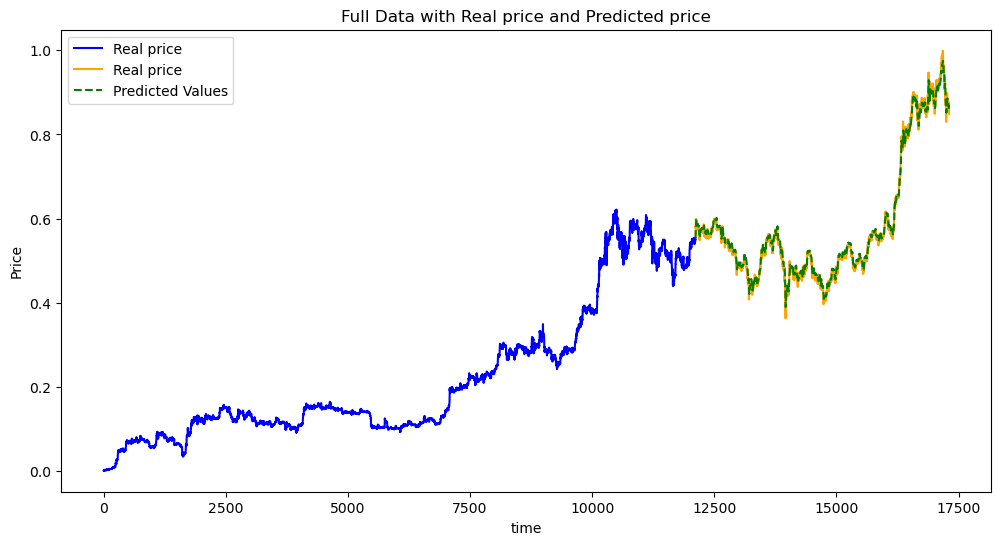

In [43]:
# Setting the sequence length for LSTM model, creating sequences from the hourly data, and applying the LSTM model to this data.
sequence_length = 20
X, y = create_sequences(hour_btc, sequence_length) # Prediction based on 20 hours 
y_train, y_test, predicted_values = lstm_model(X, y)
visualize_RNN_prediction(y_train, y_test, predicted_values)

- The predictions align well with the actual values, as expected ! 

The next phase is more complex, pushing the boundaries of what this model can do. We will implement recursive prediction with LSTM, where each predicted value is used to forecast the subsequent one. This technique is important because, in earlier examples, the model was able to accurately predict future values since it used the true value for each step. However, in this case, we lack the true values for future predictions.

In the following example, we will forecast the prices for the next 5 hours.

In [ ]:
t = 5
X, y = create_sequences_recursive(hour_btc, sequence_length)
prediction = recursive_prediction(X, y, t)

Epoch 1/100


/opt/conda/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 74ms/step - loss: 0.0288
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 0.0018
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 0.0013
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - loss: 0.0011
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - loss: 8.9302e-04
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 8.1964e-04
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 6.7590e-04
Epoch 8/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 6.9156e-04
Epoch 9/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 6.2233e-04
Epoch 10/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - loss: 5.8778e-04
Epoch 11/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 5.5871e-04
Epoch 12/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - loss: 5.0666e-04
Epoch 13/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - loss: 4.8537e-04
Epoch 14/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 4.7082e-04
Epoch 15/100
50/50 ━━━━━━━━━━

In [62]:
prediction = inverse_scalling(prediction, hour_data)

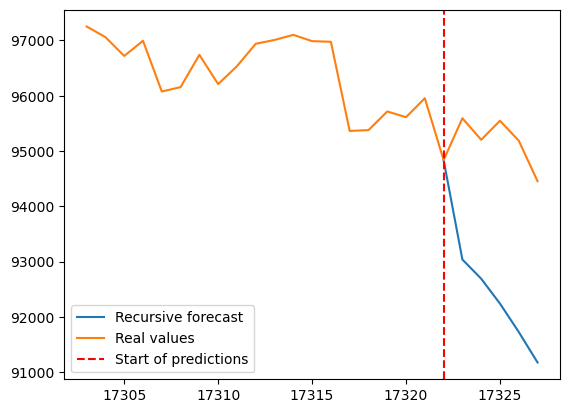

In [80]:
#Visualizing the results of the recursive prediction.

#The red dashed line at 'sequence_length' shows where the recursive prediction begins in the time series.
N = len(hour_data['close'])
x_indices = np.arange(N - sequence_length-5, N - sequence_length + len(prediction)-5)

plt.plot(x_indices[-6:], prediction[-6:], label='Recursive forecast')
plt.plot(x_indices, hour_data['close'][-25:], label='Real values')
plt.axvline(x=N-6, color='r', linestyle='--', label='Start of predictions')
plt.legend()
plt.show()


In recursive prediction, the model faces difficulties in capturing the non-linear relationships seen in historical data when applied to its own predicted values.

## **IV. GARCH model for volatility.**

The GARCH (Generalized Autoregressive Conditional Heteroskedasticity) model is widely used for modeling and forecasting volatility in financial time series. It captures the time-varying volatility, allowing the variance of returns to change over time based on past data. The model consists of two main components: the autoregressive (AR) part, which models the past conditional variances, and the moving average (MA) part, which models the impact of past squared errors. The parameters **p** and **q** represent the order of the AR and MA terms, respectively. Specifically, **p** refers to the number of lag observations in the variance equation, while **q** refers to the number of lag squared error terms. Additionally, the choice of error distribution is crucial in volatility modeling. In the case of a Student’s t-distribution, it accounts for heavier tails in the data, making it more suitable for financial time series that often exhibit extreme returns or outliers.

**1. Daily prediction.**

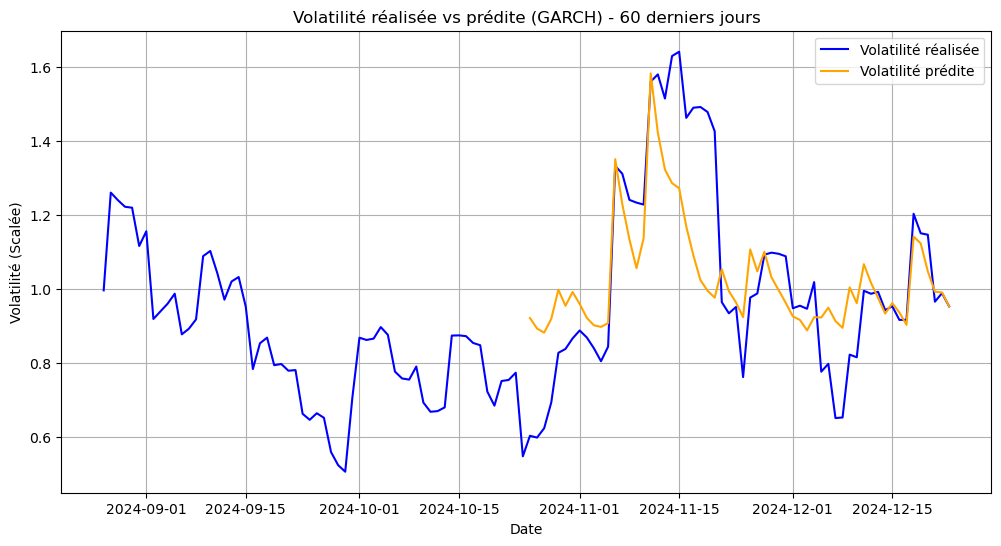

Évaluation des prédictions de volatilité :
Mean Squared Error (MSE): 0.0336
Root Mean Squared Error (RMSE): 0.1832
Mean Absolute Error (MAE): 0.1341
R² Score: 0.5493


In [ ]:
# Load the data.
data_d = pd.read_csv('BTCUSDT_daily_2023.csv')  # Replace with your file.
data_d['timestamp'] = pd.to_datetime(data_d['timestamp'])
data_d.set_index('timestamp', inplace=True)

garch_analysis(data_d,1,1)

- For the daily prediction, we implement a simple GARCH(1, 1) model with a normal distribution. We observe that the R² is not exceptionally high, but the prediction does not seem unreasonable. The trends and peaks appear to be fairly well captured. The errors are relatively low and suggest an acceptable level of error.

**Let's move on to the hourly prediction.**


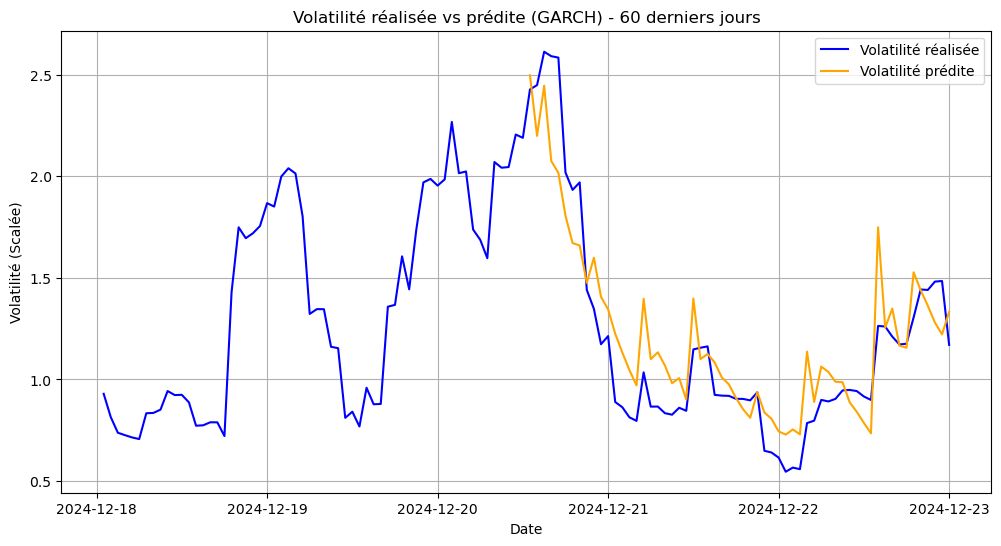

Évaluation des prédictions de volatilité :
Mean Squared Error (MSE): 0.0441
Root Mean Squared Error (RMSE): 0.2101
Mean Absolute Error (MAE): 0.1702
R² Score: 0.8353


In [ ]:
# Load the data
data_h = pd.read_csv('BTCUSDT_hourly_2023.csv')
data_h['timestamp'] = pd.to_datetime(data_h['timestamp'])
data_h.set_index('timestamp', inplace=True)

garch_analysis(data_h,2,2,'t')

Next, for the hourly prediction, the model needed improvement as the previous one yielded average results. To achieve acceptable errors and a  good R², a more advanced model was required, specifically a GARCH(2, 2) model with a Student's t-distribution.

## **V. Dashboard**


**Open the Dashboard file and run the Streamlit module by following the instructions in the terminal.**